# Generative continual learning notebook

This notebook contains code to train a model on MNIST in the class incremental setting, where the dataset is passed to the model in batches of two numbers at a time. The model trains both a GAN model to generate new samples and a MLP to actually classify the the images. The GAN learns to generate samples from the first task, and for the next task it is trained on the new data and on data generated by itself. This way the GAN can learn to generate samples from the new tasks without forgetting the old task. As expected the quality of the generated images declines the further in the past a certain task is, since training the model with images produced by itself leads to poorer and poorer results. Similarly the solver, which needs to distinguish between 10 classes, is trained on the new data and on the generated samples, so as to help it remember the old tasks. Since the quality of the produced samples deteriorates we expect also the performance of the models on older tasks to decline accordingly. 

## Imports

In [109]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Subset, TensorDataset, DataLoader, Dataset
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from random import shuffle

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

## Utils

In [110]:

def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307), (0.3081)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)])

    train_dataset = datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices[:])[0])
    return split_dataset

In [111]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

def print_gpu_memory():
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print(f"Memory Allocated: {allocated / 1024**2:.2f} MB")
    print(f"Memory Reserved: {reserved / 1024**2:.2f} MB")

## Dataset definition

In [112]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels, transform=None):
        """
        Args:
            samples (list or ndarray): List of samples.
            labels (list or ndarray): List of corresponding labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.samples = samples
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

def collate_fn(batch, device):
    inputs, targets = zip(*batch)
    inputs = torch.stack(inputs).to(device)
    targets = torch.tensor(targets).to(device)
    return inputs, targets

def plot_results(tensor, num_matrices=12, cols=4):
    rows = (num_matrices + cols - 1) // cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    fig.subplots_adjust(hspace=0., wspace=0.)  # Adjust the space between subplots
    
    for i in range(num_matrices):
        ax = axes[i // cols, i % cols]
        ax.imshow(tensor[i, 0].cpu().numpy(), cmap='gray')
        ax.axis('off')
    
    # Turn off any extra subplots
    for i in range(num_matrices, rows * cols):
        fig.delaxes(axes.flatten()[i])
    
    plt.show()

## Generator and discriminator

For the GANs a couple of models were tested. In the first case both generator and discriminator are fully connected neural network. To improve the stability and quality of the model I also tested a convolutional generator and discriminator. In the end the convolutional models had better performance and were the ones used.

In [113]:
class Generator(torch.nn.Module):
    def __init__(self, args):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(args['z_dim'], 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, args['g_output_dim'])
        self.args = args
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = args['lr_gen'])

    # forward method
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        return x.view((self.args['bs'], 1, self.args['in_size'], self.args['in_size']))

class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(args['g_output_dim'], 1024*2)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = args['lr_gen']*2)

    # forward method
    def forward(self, x):
        bs = x.shape[0]
        x = x.view(x.shape[0], -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.fc4(x))
        return x.view((bs, 1))

In [114]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator2(nn.Module):
    def __init__(self, args):
        super(Generator2, self).__init__()
        ngpu = args['ngpu']
        nc = args['nc']
        nz = args['nz']
        ngf = args['ngf']
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = args['lr_gen'], betas=(0.5, 0.999))

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

class Discriminator2(nn.Module):
    def __init__(self, args):
        super(Discriminator2, self).__init__()
        ngpu = args['ngpu']
        nc = args['nc']
        ndf = args['ndf']
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = args['lr_gen'], betas=(0.5, 0.999))

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1)

## Class incremental model

In [115]:
class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        self.solver = MLP(self.args)
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        self.G = Generator2(self.args)
        self.G.apply(weights_init)
        self.D = Discriminator2(self.args)
        self.D.apply(weights_init)
        self.last_labels = None
        self.solver_loss = []
        self.d_loss = []
        self.g_loss = []
        self.task = 0
        if torch.cuda.is_available():
            self.solver.cuda()
            self.G.cuda()
            self.D.cuda()

    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}


    def train(self):
        generated_data = None
        for task, data in self.train_datasets.items():
            self.task = int(task)
            print(f"Starting task {task}. Number of samples is {len(data)}")
            combined_data = self.combine_datasets(data, generated_data)
            print(f"combined_data is of size {len(combined_data)}")
            loader = DataLoader(combined_data, batch_size=self.args['bs'], shuffle=True, collate_fn=lambda x: collate_fn(x, self.args['device']))
            if self.task < self.args['num_tasks']-1:
                print("Training G and D.")
                for epoch in range(self.args['epochs_gen'][self.task]):
                    self.train_epoch_generator(loader)
                    print(f"Epoch {epoch} done.")
            print("Training the solver.")
            for epoch in range(self.args['epochs_sol']):
                self.train_epoch_solver(loader)
                # correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                self.validate()
                print(f"Epoch {epoch} done. Validation accuracy: {self.acc[task][-1]}")
            self.validate(end_of_epoch=True)
            print("Generating the data.")
            generated_data = self.get_generated_dataset(data, generated_data)
            # Reset G and D ready for next training
            self.G.apply(weights_init)
            self.D.apply(weights_init)
            # gen_data.append(new_data)

    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.solver.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=self.args['bs'], collate_fn=lambda x: collate_fn(x, self.args['device']))
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.solver(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.solver.train()

    def train_step_G(self, x):
        torch.autograd.set_detect_anomaly(True)
        #=======================Train the generator=======================#
        self.G.zero_grad()

        z = Variable(torch.randn(self.args['bs'], self.args['z_dim'], 1, 1).to(self.args['device']))
        y = Variable(torch.ones(self.args['bs'], 1).to(self.args['device']))

        G_output = self.G(z)
        D_output = self.D(G_output)
        G_loss = self.G.criterion(D_output, y)

        # gradient backprop & optimize ONLY G's parameters
        G_loss.backward()
        self.G.optimizer.step()

        return G_loss.data.item()

    def train_step_D(self, x):
        torch.autograd.set_detect_anomaly(True)
        #=======================Train the discriminator=======================#
        self.D.zero_grad()

        # train discriminator on real
        # x_real = x.view(-1, self.args['g_output_dim'])
        x_real = x
        y_real = torch.ones(x_real.shape[0], 1)
        x_real, y_real = Variable(x_real.to(self.args['device'])), Variable(y_real.to(self.args['device']))
        D_output = self.D(x_real)

        D_real_loss = self.D.criterion(D_output, y_real)
        D_real_score = D_output

        # train discriminator on fake
        z = Variable(torch.randn(self.args['bs'], self.args['z_dim'], 1, 1).to(self.args['device']))
        x_fake, y_fake = self.G(z), Variable(torch.zeros(self.args['bs'], 1).to(self.args['device']))

        D_output = self.D(x_fake)
        D_fake_loss = self.D.criterion(D_output, y_fake)
        D_fake_score = D_output

        # gradient backprop & optimize ONLY D's parameters
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        self.D.optimizer.step()

        return  D_loss.data.item()

    def train_step_solver(self, batch):
        torch.autograd.set_detect_anomaly(True)
        self.solver.train()
        x, y = batch

        output = self.solver(x)
        loss = self.solver.criterion(output, y)

        self.solver.optimizer.zero_grad()
        loss.backward()

        self.solver.optimizer.step()
        return loss.item()

    def get_generated_dataset(self, data_real, data_generated=None):
        if data_generated is not None:
            del data_generated
            torch.cuda.empty_cache()
        if self.last_labels is None:
            self.last_labels = self.get_current_labels(data_real)
        else:
            self.last_labels = torch.cat((self.last_labels, self.get_current_labels(data_real)))
        new_samples = []
        outputs = []
        z = Variable(torch.randn(self.args['n_gen_samples']*(self.task+1), self.args['z_dim'], 1, 1).to(self.args['device']))
        with torch.no_grad():
            for i in range(int(z.shape[0]/self.args['bs'])):
                new_samples.append(self.G(z[i*self.args['bs']:(i+1)*self.args['bs']]))
                torch.cuda.empty_cache()
                outputs.append(self.solver(new_samples[-1]))
                torch.cuda.empty_cache()
            new_samples = torch.cat(new_samples, dim=0)
            outputs = torch.cat(outputs, dim=0)
            
        new_ys = torch.topk(outputs, axis=1, k=1)[1].squeeze(1)
        new_samples = new_samples.to('cpu')
        new_ys = new_ys.to('cpu')
        new_data = TensorDataset(new_samples, new_ys)
        print(f"Current labels seen: {self.last_labels}")
        print("Labels in new data")
        for y in torch.unique(new_ys):
            print(f"Number of samples for label {y}: {torch.sum(new_ys==y)}")
        plot_results(new_samples)
        return new_data

    def get_generated_sample(self, label):
        """ Unused."""
        res = torch.zeros([0, 1, self.args['in_size'], self.args['in_size']]).to(self.args['device'])
        iter = 0
        while iter<self.args['gen_max_iters']:
            z = Variable(torch.randn(self.args['bs'], self.args['z_dim'], 1, 1).to(self.args['device']))
            x = self.G(z)
            y = self.solver(x)
            keep_idxs = torch.where(torch.topk(y, axis=1, k=1)[1].squeeze(1) == label, True, False)
            res = torch.cat((res, x[keep_idxs, :].clone()), dim=0).detach()
            del x, y, z, keep_idxs
            torch.cuda.empty_cache()
            if res.shape[0] >= self.args['bs']:
                new_sample = res[:self.args['bs']].detach().to('cpu').clone()
                del res
                torch.cuda.empty_cache() 
                return new_sample 
            iter += 1
        raise ValueError(f"Too many iterations to generate the data. Only generated {res.shape[0]} samples.")

    def get_current_labels(self, data):
        labels = []
        for d in data:
            label = d[1]
            if not label in labels:
                labels.append(label)
            if len(labels)==2:
                return torch.tensor(labels)

    def extract_tensors(self, subset):
        if isinstance(subset, Subset):
            indices = subset.indices
            dataset = subset.dataset
            x = torch.stack([dataset[i][0] for i in indices])
            y = torch.tensor([dataset[i][1] for i in indices])
        elif isinstance(subset, TensorDataset):
            x, y = subset.tensors
        else:
            raise TypeError("Unsupported dataset type")
        return x, y

    def combine_datasets(self, data1, data2):
        if data1 is None:
            return data2
        if data2 is None:
            return data1
        return torch.utils.data.ConcatDataset([data1, data2])

    def train_epoch_generator(self, dataloader):
        for batch in dataloader:
            x, y = batch
            self.d_loss.append(self.train_step_D(x))
            self.g_loss.append(self.train_step_G(x))
        self.G.zero_grad(set_to_none=True)
        self.D.zero_grad(set_to_none=True)
        self.G.optimizer.zero_grad(set_to_none=True)
        self.D.optimizer.zero_grad(set_to_none=True)
        
    def train_epoch_solver(self, dataloader):
        self.solver.train()
        for batch in dataloader:
            self.solver_loss.append(self.train_step_solver(batch))
        self.solver.zero_grad(set_to_none=True)
        self.solver.optimizer.zero_grad(set_to_none=True)

class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = args['lr_gen'], betas=(0.5, 0.999))

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x


## Running the model

For time constraints I ran only a couple of experiments. The hyperparameter that I changed is the number of samples that I generate from the previous classes. The idea is to observe how fast the model forgets the previous tasks if fewer examples are generated.  

### First run

Starting task 0. Number of samples is 12054
combined_data is of size 12054
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.9839195979899498
Epoch 1 done. Validation accuracy: 0.9819095477386934
Epoch 2 done. Validation accuracy: 0.9321608040201005
Generating the data.
Current labels seen: tensor([0, 3])
Labels in new data
Number of samples for label 0: 4180
Number of samples for label 3: 7596


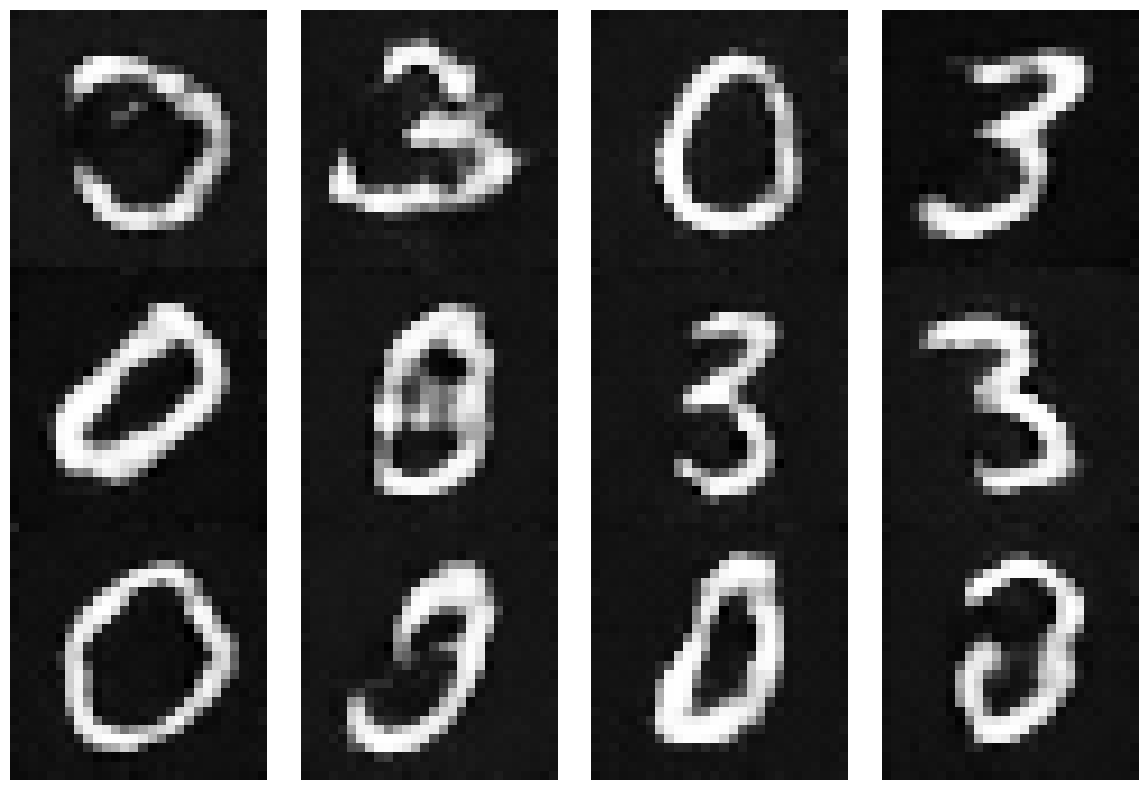

Starting task 1. Number of samples is 12660
combined_data is of size 24436
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.9856665074056379
Epoch 1 done. Validation accuracy: 0.9904443382704252
Epoch 2 done. Validation accuracy: 0.9913999044433827
Generating the data.
Current labels seen: tensor([0, 3, 1, 6])
Labels in new data
Number of samples for label 0: 33
Number of samples for label 3: 23775


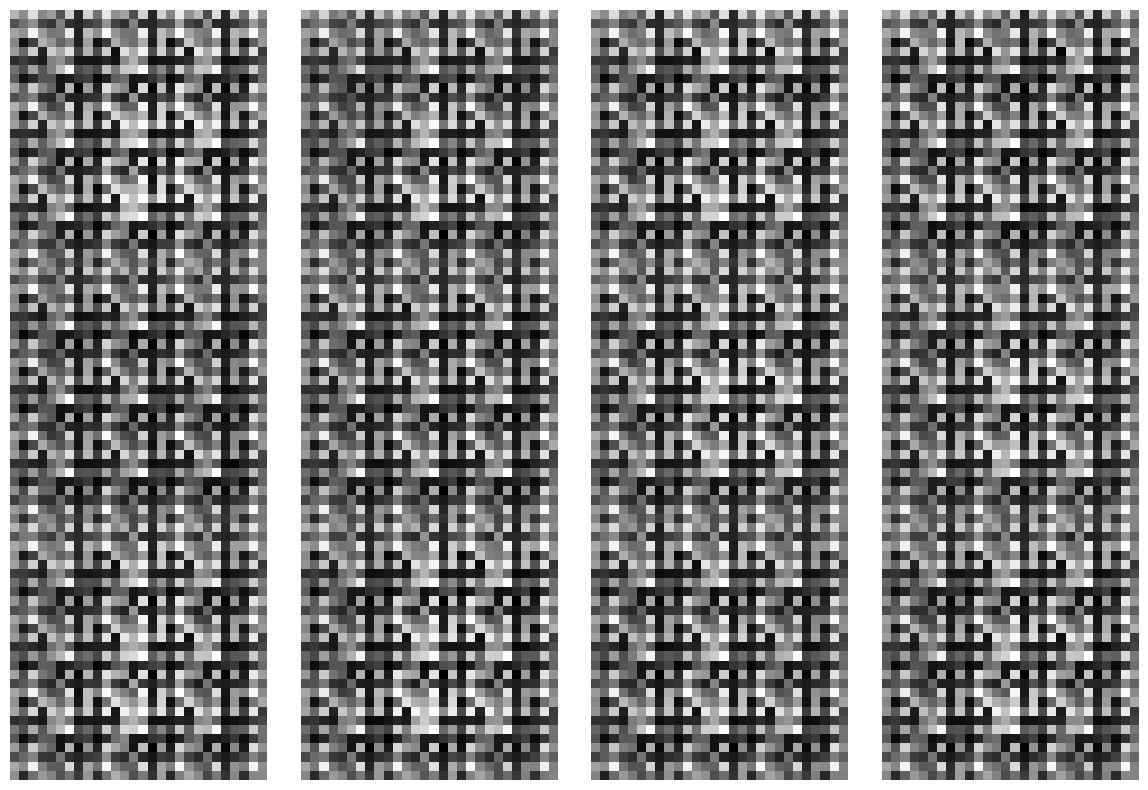

Starting task 2. Number of samples is 11272
combined_data is of size 35080
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.969989281886388
Epoch 1 done. Validation accuracy: 0.9764201500535906
Epoch 2 done. Validation accuracy: 0.9715969989281886
Generating the data.
Current labels seen: tensor([0, 3, 1, 6, 5, 8])
Labels in new data
Number of samples for label 3: 8465
Number of samples for label 5: 27375


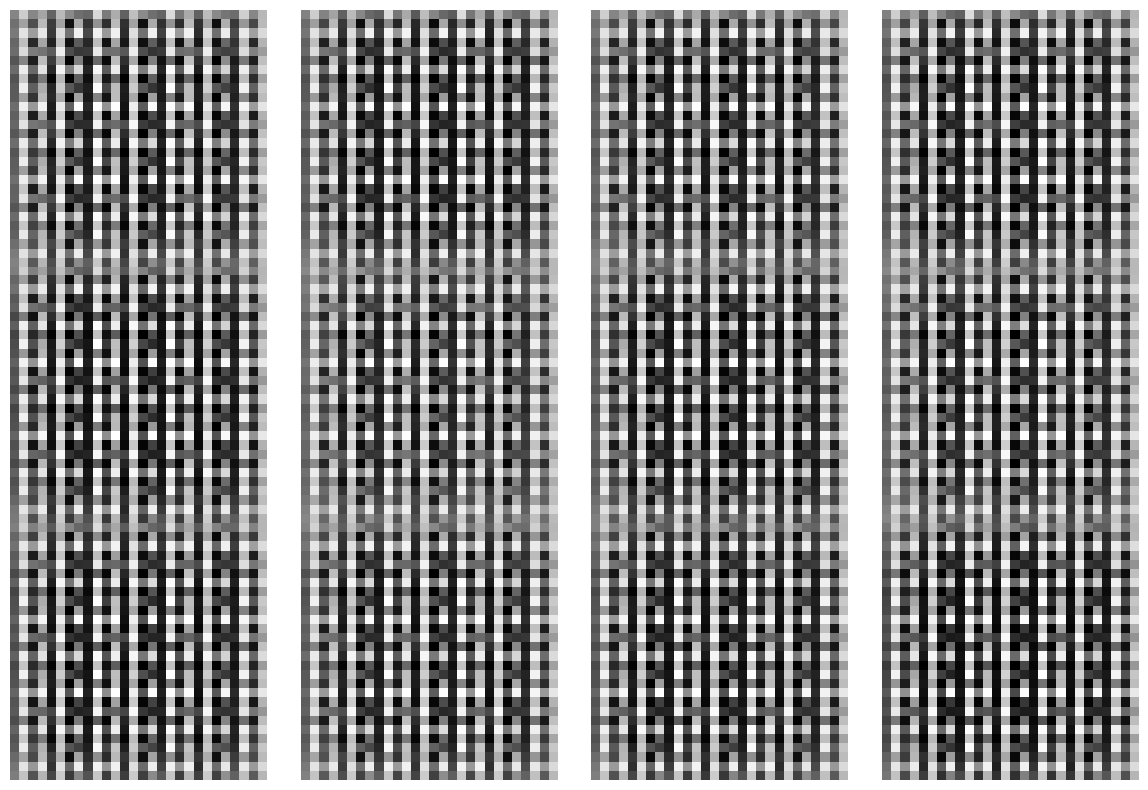

Starting task 3. Number of samples is 12214
combined_data is of size 48054
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.9651448208149239
Epoch 1 done. Validation accuracy: 0.9695630829651448
Epoch 2 done. Validation accuracy: 0.9779086892488954
Generating the data.
Current labels seen: tensor([0, 3, 1, 6, 5, 8, 9, 7])
Labels in new data
Number of samples for label 3: 11259
Number of samples for label 5: 36613


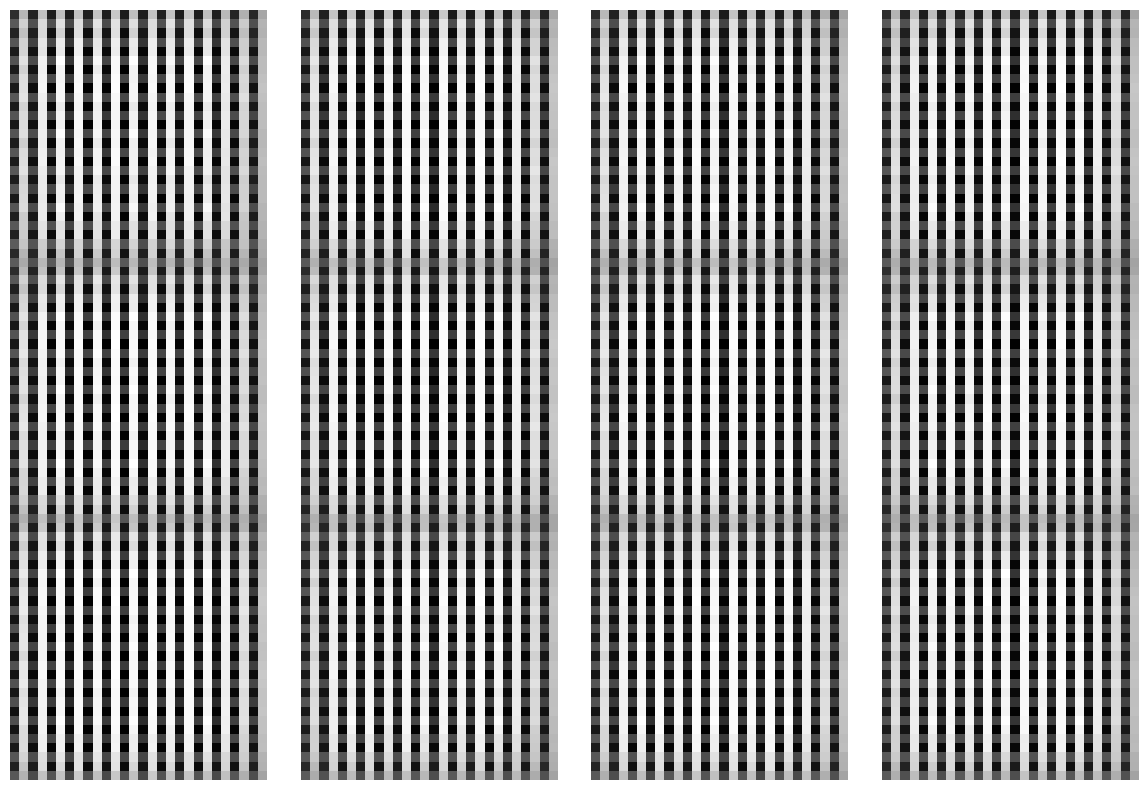

Starting task 4. Number of samples is 11800
combined_data is of size 59672
Training the solver.
Epoch 0 done. Validation accuracy: 0.980635551142006
Epoch 1 done. Validation accuracy: 0.9895729890764647
Epoch 2 done. Validation accuracy: 0.9905660377358491
Generating the data.
Current labels seen: tensor([0, 3, 1, 6, 5, 8, 9, 7, 4, 2])
Labels in new data
Number of samples for label 2: 56658
Number of samples for label 3: 2627
Number of samples for label 4: 575
Number of samples for label 5: 44


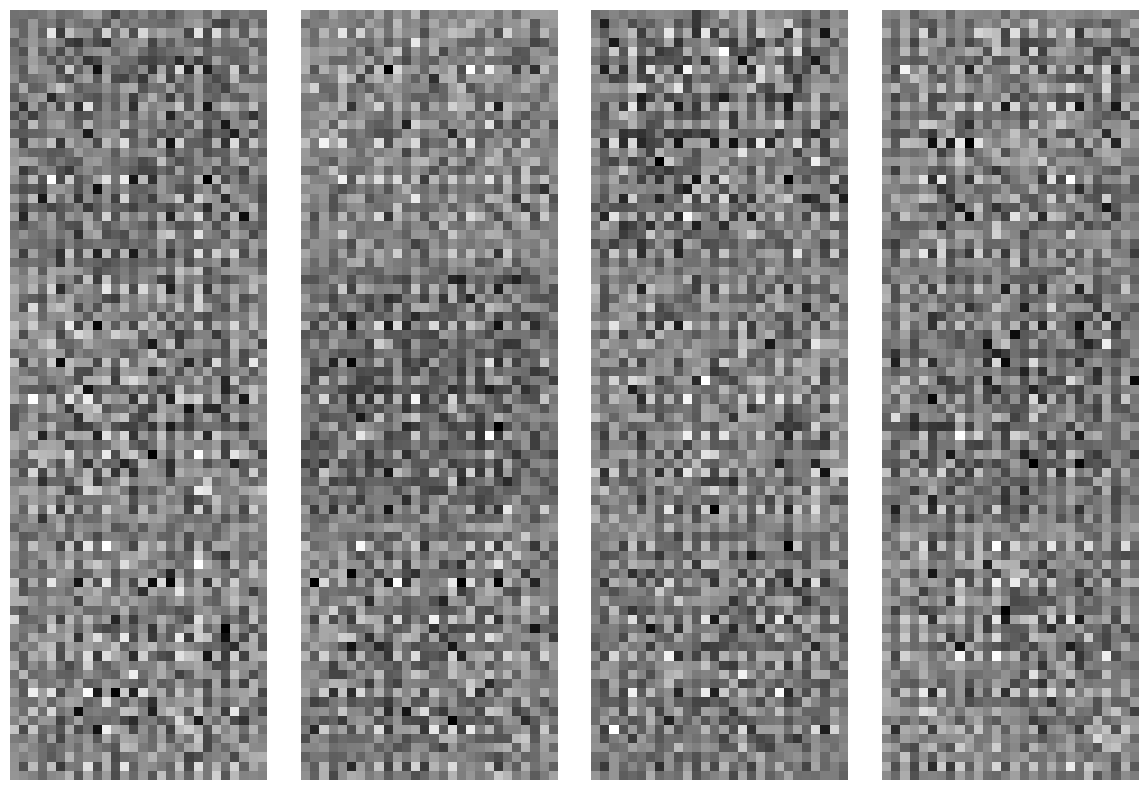

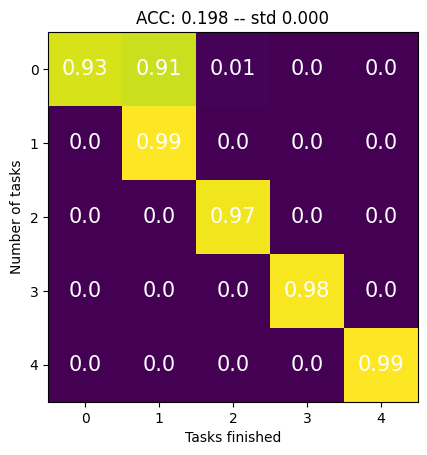

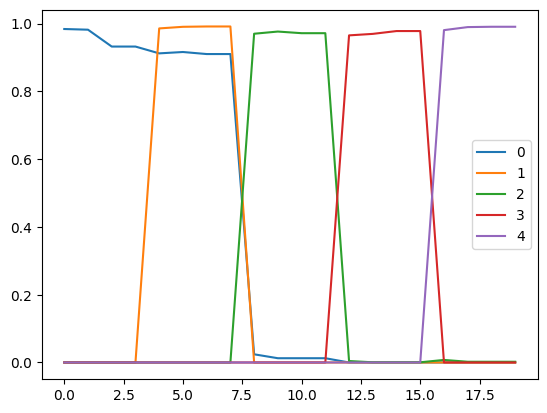

The average accuracy at the end of sequence is: 0.199
BWT:'-0.968'
FWT:'-0.145'


In [117]:
args = {
    'lr_gen': 2e-4,
    'lr_sol': 1e-5,
    'bs': 256,
    'epochs_gen': [6,8,10,12],
    'epochs_sol': 3,
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 256,
    'n_gen_samples': 12000,
    'z_dim': 100,
    'nz': 100,
    'ngf': 128,
    'ndf': 128,
    'nc': 1,
    'ngpu': 1,
    'device': device,
    'g_output_dim': 28*28,
    'gen_max_iters': 100000,
    }

classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='./dataMNIST/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

agent = Agent(args, train_tasks, val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

### Second run

Starting task 0. Number of samples is 11693
combined_data is of size 11693
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.9882413087934561
Epoch 1 done. Validation accuracy: 0.9918200408997955
Epoch 2 done. Validation accuracy: 0.9923312883435583
Generating the data.
Current labels seen: tensor([4, 8])
Labels in new data
Number of samples for label 4: 555
Number of samples for label 8: 469


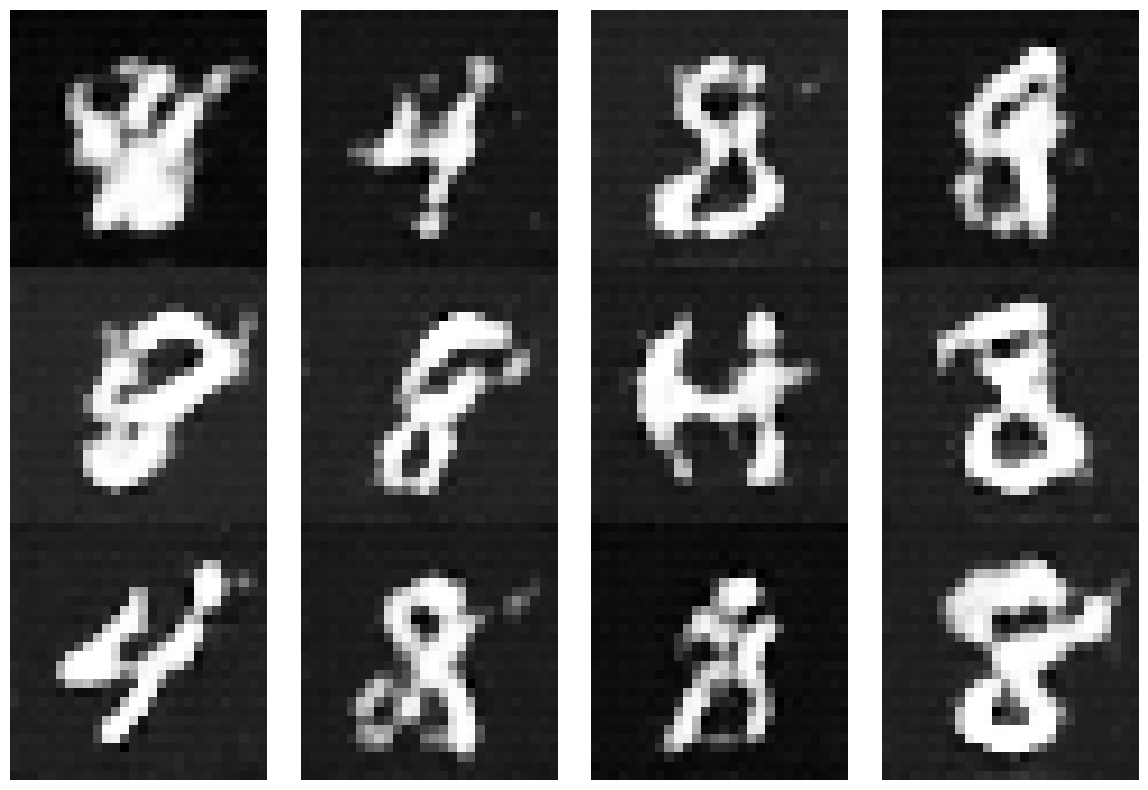

Starting task 1. Number of samples is 11867
combined_data is of size 12891
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.990849008642603
Epoch 1 done. Validation accuracy: 0.9913573970513472
Epoch 2 done. Validation accuracy: 0.9949161159125572
Generating the data.
Current labels seen: tensor([4, 8, 9, 6])
Labels in new data
Number of samples for label 4: 85
Number of samples for label 6: 1039
Number of samples for label 8: 25
Number of samples for label 9: 1155


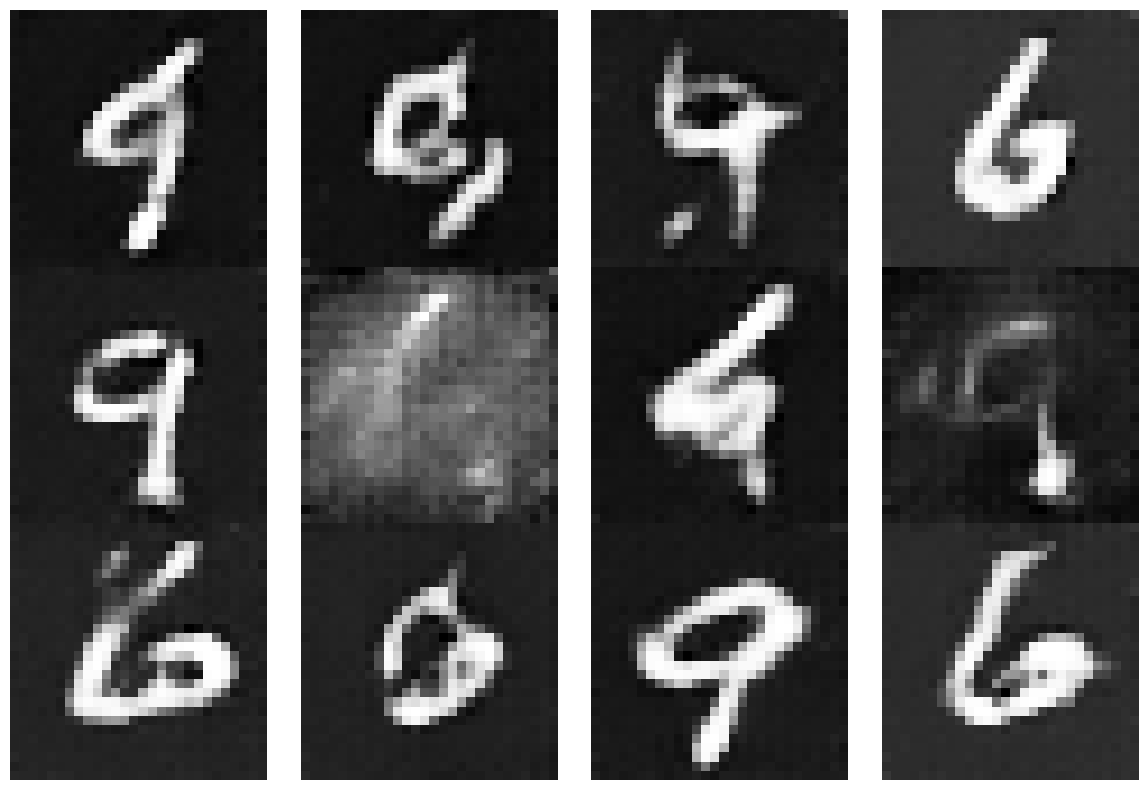

Starting task 2. Number of samples is 11344
combined_data is of size 13648
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.968482905982906
Epoch 1 done. Validation accuracy: 0.9877136752136753
Epoch 2 done. Validation accuracy: 0.9882478632478633
Generating the data.
Current labels seen: tensor([4, 8, 9, 6, 5, 0])
Labels in new data
Number of samples for label 0: 1566
Number of samples for label 4: 2
Number of samples for label 5: 1439
Number of samples for label 6: 225
Number of samples for label 9: 352


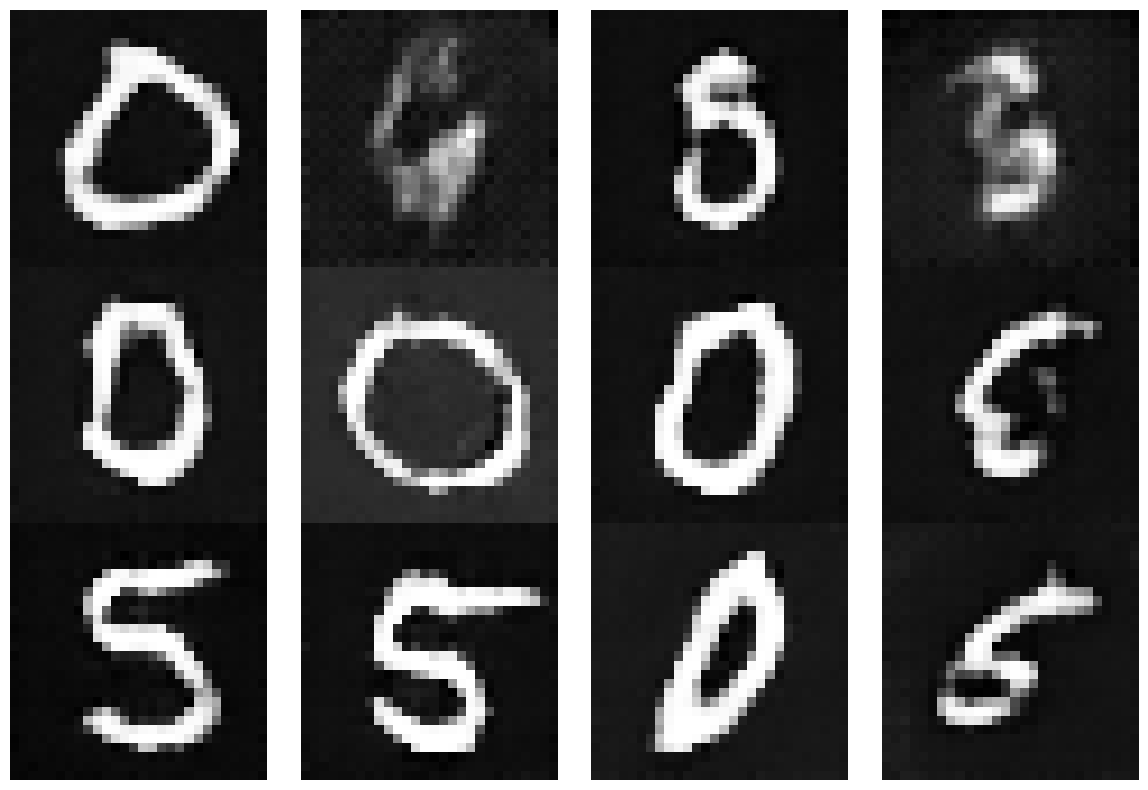

Starting task 3. Number of samples is 13007
combined_data is of size 16591
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.9819694868238558
Epoch 1 done. Validation accuracy: 0.984743411927878
Epoch 2 done. Validation accuracy: 0.9875173370319001
Generating the data.
Current labels seen: tensor([4, 8, 9, 6, 5, 0, 1, 7])
Labels in new data
Number of samples for label 0: 318
Number of samples for label 1: 1815
Number of samples for label 5: 276
Number of samples for label 6: 225
Number of samples for label 7: 1864
Number of samples for label 9: 110


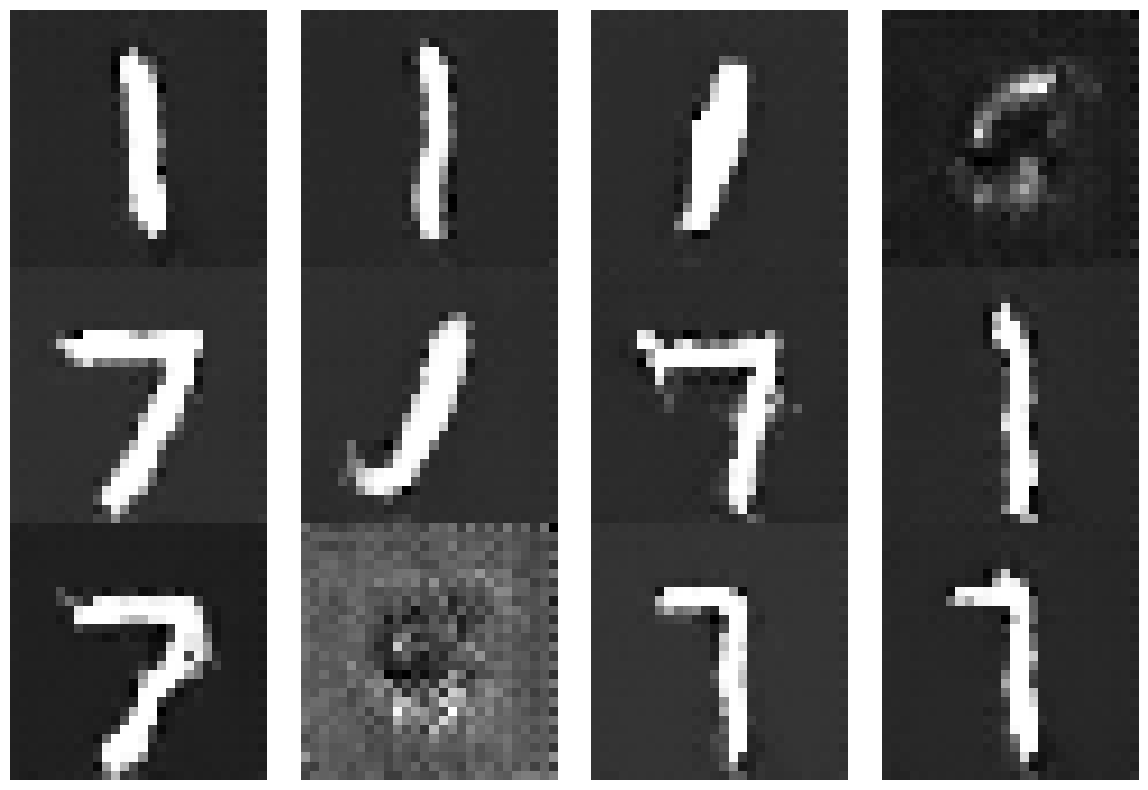

Starting task 4. Number of samples is 12089
combined_data is of size 16697
Training the solver.
Epoch 0 done. Validation accuracy: 0.9534769833496572
Epoch 1 done. Validation accuracy: 0.9696376101860921
Epoch 2 done. Validation accuracy: 0.9755142017629774
Generating the data.
Current labels seen: tensor([4, 8, 9, 6, 5, 0, 1, 7, 2, 3])
Labels in new data
Number of samples for label 0: 55
Number of samples for label 6: 5833


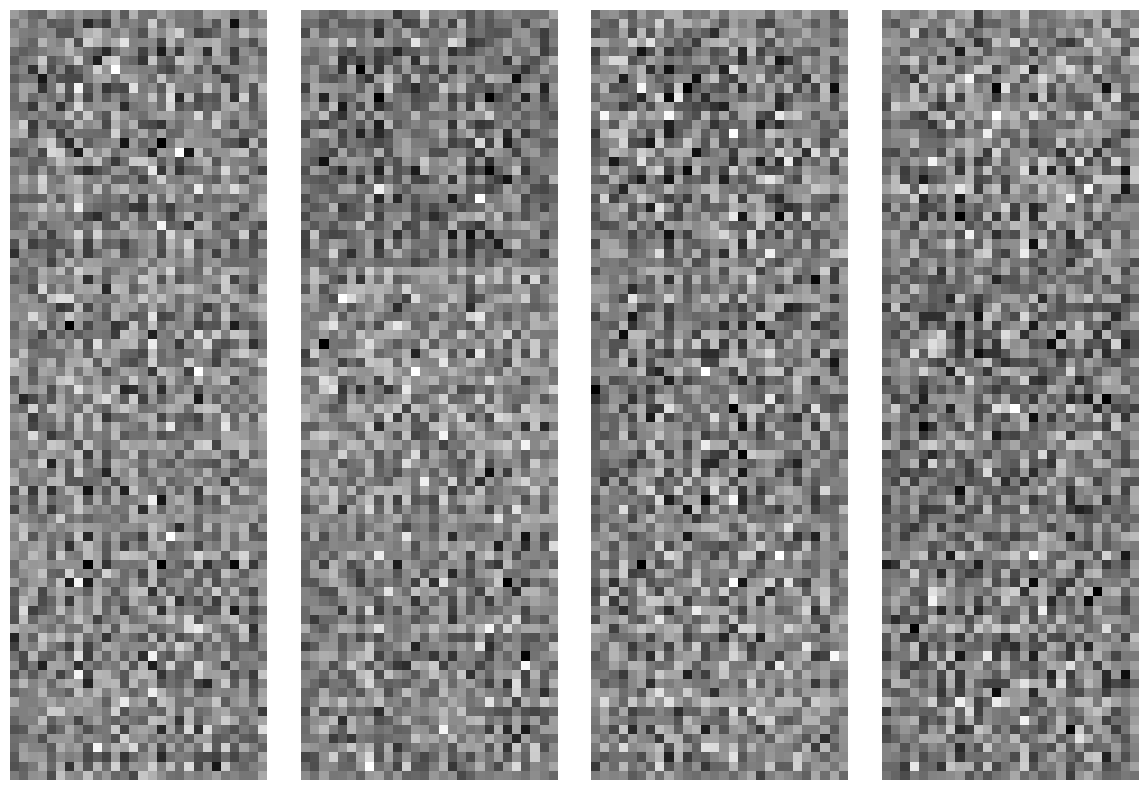

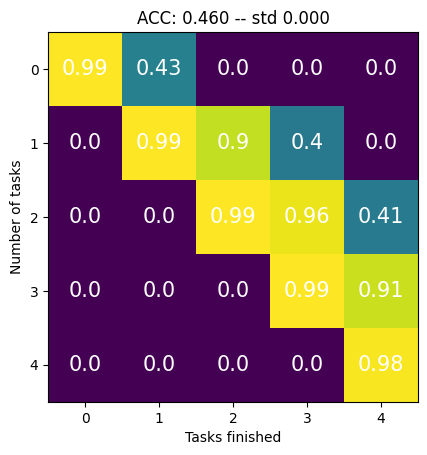

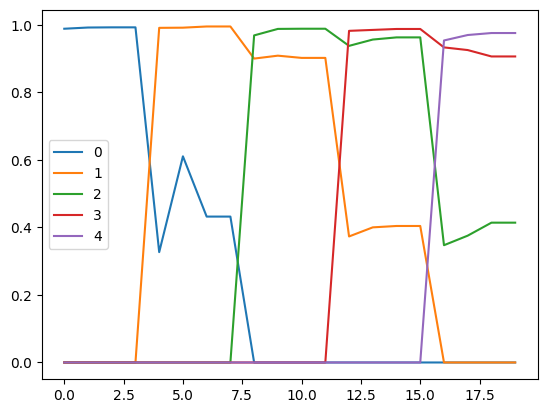

The average accuracy at the end of sequence is: 0.459
BWT:'-0.661'
FWT:'-0.116'


In [118]:
args = {
    'lr_gen': 2e-4,
    'lr_sol': 1e-5,
    'bs': 256,
    'epochs_gen': [6,8,10,12],
    'epochs_sol': 3,
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 256,
    'n_gen_samples': 1200,
    'z_dim': 100,
    'nz': 100,
    'ngf': 128,
    'ndf': 128,
    'nc': 1,
    'ngpu': 1,
    'device': device,
    'g_output_dim': 28*28,
    'gen_max_iters': 100000,
    }

classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='./dataMNIST/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

agent = Agent(args, train_tasks, val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

Starting task 0. Number of samples is 11800
combined_data is of size 11800
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.9707050645481629
Epoch 1 done. Validation accuracy: 0.958291956305859
Epoch 2 done. Validation accuracy: 0.9846077457795432
Generating the data.
Current labels seen: tensor([4, 2])
Labels in new data
Number of samples for label 2: 28059
Number of samples for label 4: 31845


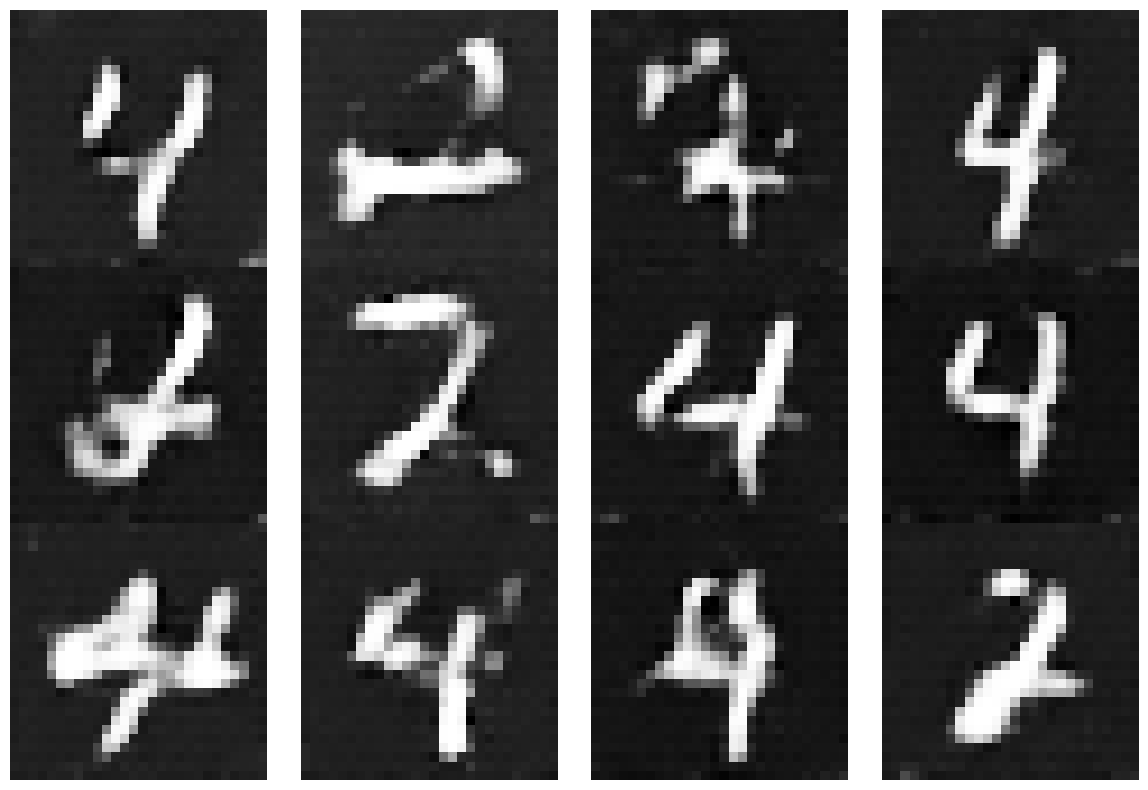

Starting task 1. Number of samples is 12080
combined_data is of size 71984
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.962852897473997
Epoch 1 done. Validation accuracy: 0.9791976225854383
Epoch 2 done. Validation accuracy: 0.9821693907875185
Generating the data.
Current labels seen: tensor([4, 2, 9, 3])
Labels in new data
Number of samples for label 2: 17549
Number of samples for label 3: 23380
Number of samples for label 4: 78879


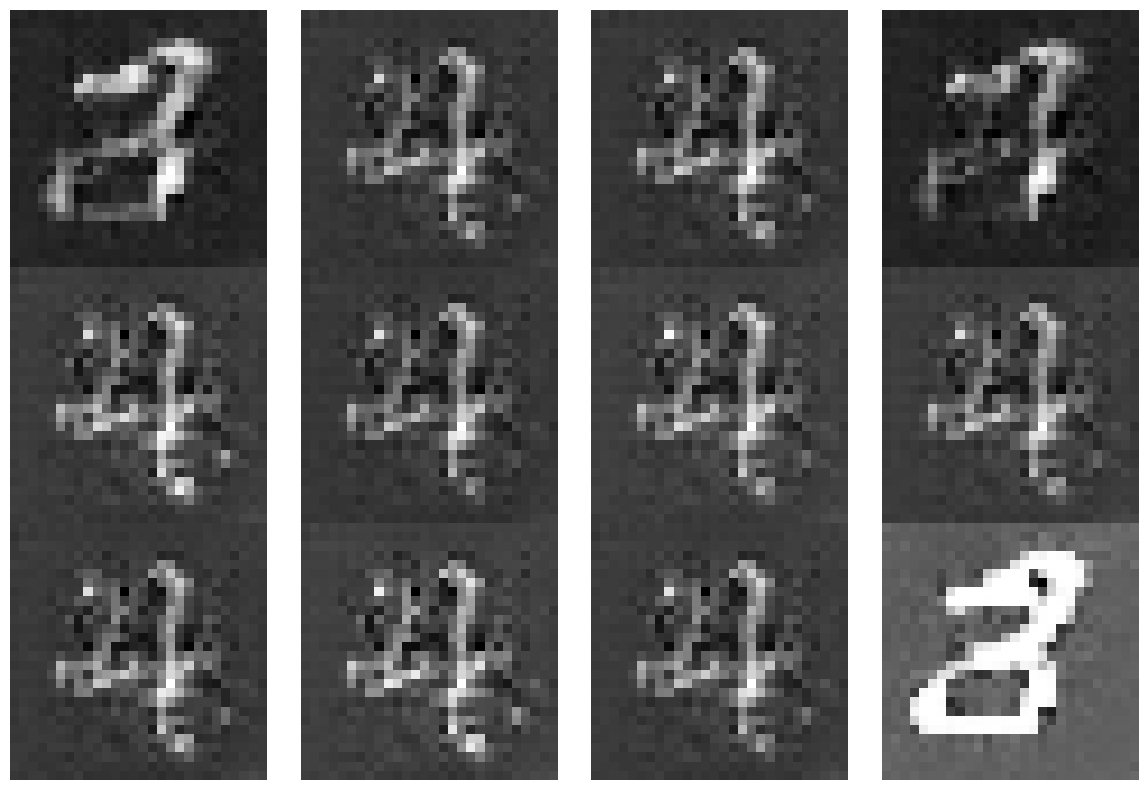

Starting task 2. Number of samples is 12593
combined_data is of size 132401
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.9777145566619251
Epoch 1 done. Validation accuracy: 0.9914651493598862
Epoch 2 done. Validation accuracy: 0.9867235656709341
Generating the data.
Current labels seen: tensor([4, 2, 9, 3, 1, 8])
Labels in new data
Number of samples for label 2: 5462
Number of samples for label 4: 172476
Number of samples for label 8: 2030


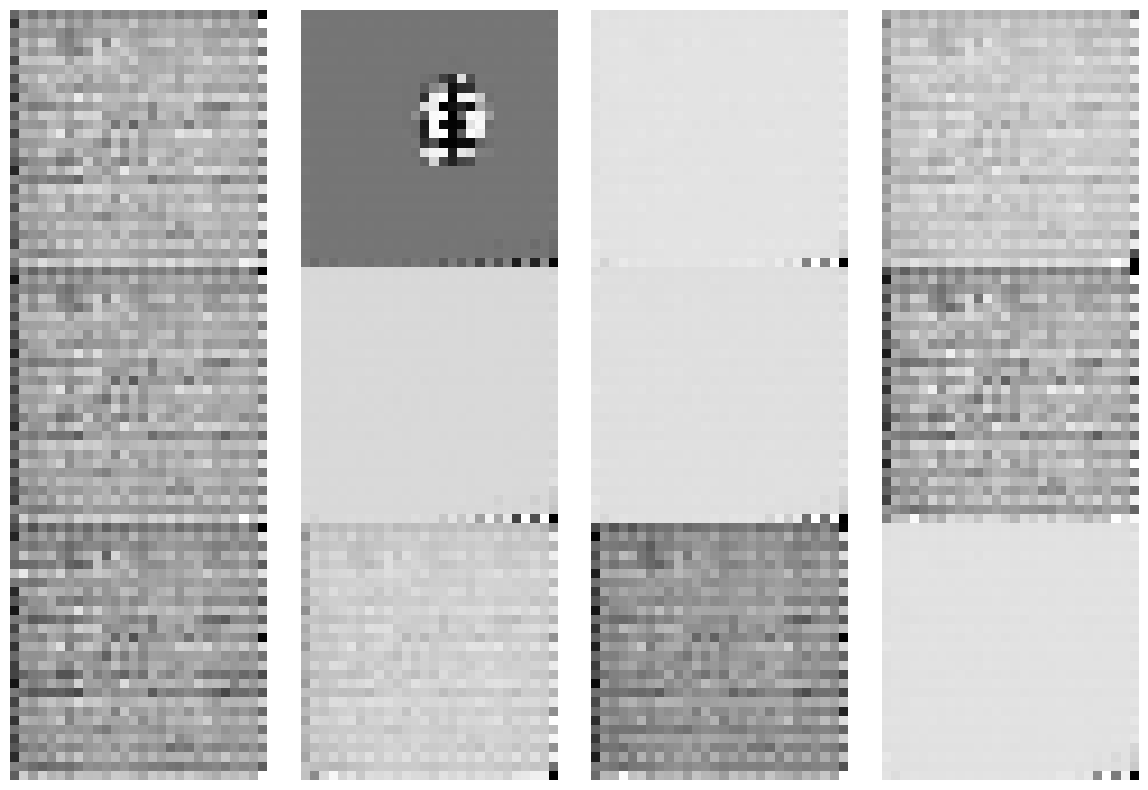

Starting task 3. Number of samples is 11339
combined_data is of size 191307
Training G and D.
Epoch 0 done.
Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Training the solver.
Epoch 0 done. Validation accuracy: 0.9794594594594594
Epoch 1 done. Validation accuracy: 0.9891891891891892
Epoch 2 done. Validation accuracy: 0.9897297297297297
Generating the data.
Current labels seen: tensor([4, 2, 9, 3, 1, 8, 5, 6])
Labels in new data
Number of samples for label 2: 203796
Number of samples for label 4: 36076


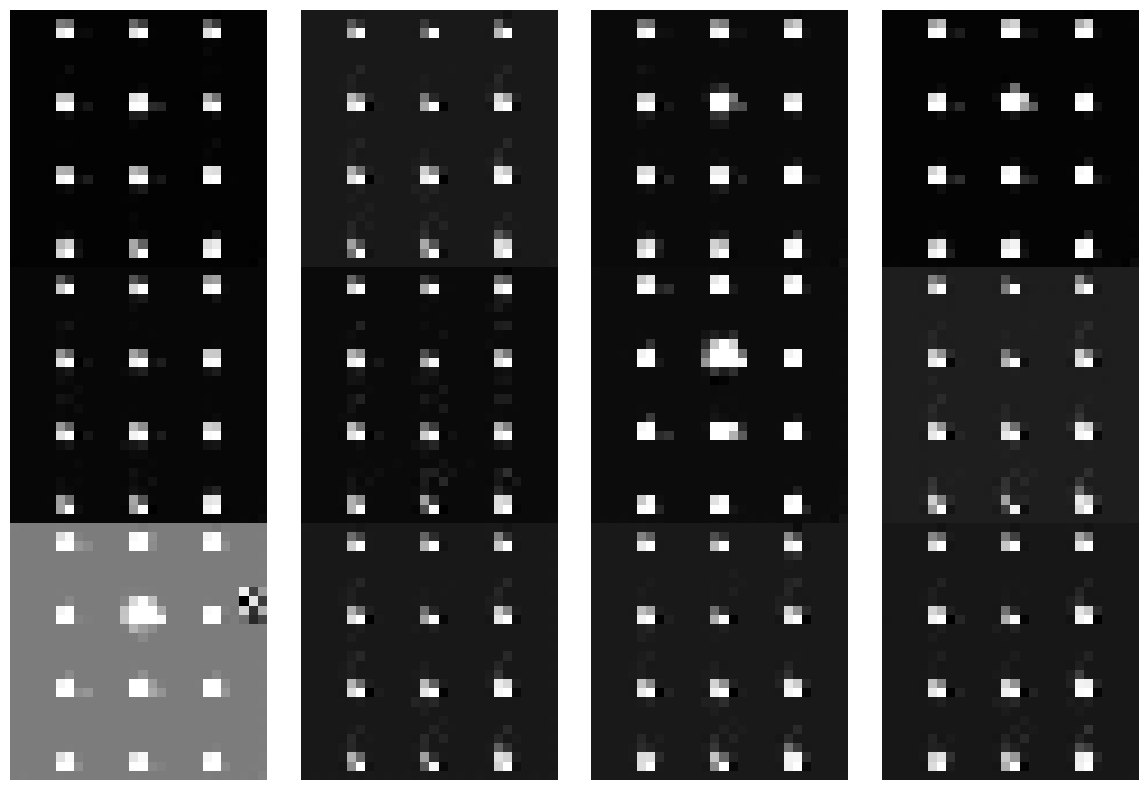

Starting task 4. Number of samples is 12188
combined_data is of size 252060
Training the solver.
Epoch 0 done. Validation accuracy: 0.9950199203187251
Epoch 1 done. Validation accuracy: 0.9945219123505976
Epoch 2 done. Validation accuracy: 0.9950199203187251
Generating the data.
Current labels seen: tensor([4, 2, 9, 3, 1, 8, 5, 6, 0, 7])
Labels in new data
Number of samples for label 2: 515
Number of samples for label 4: 299261


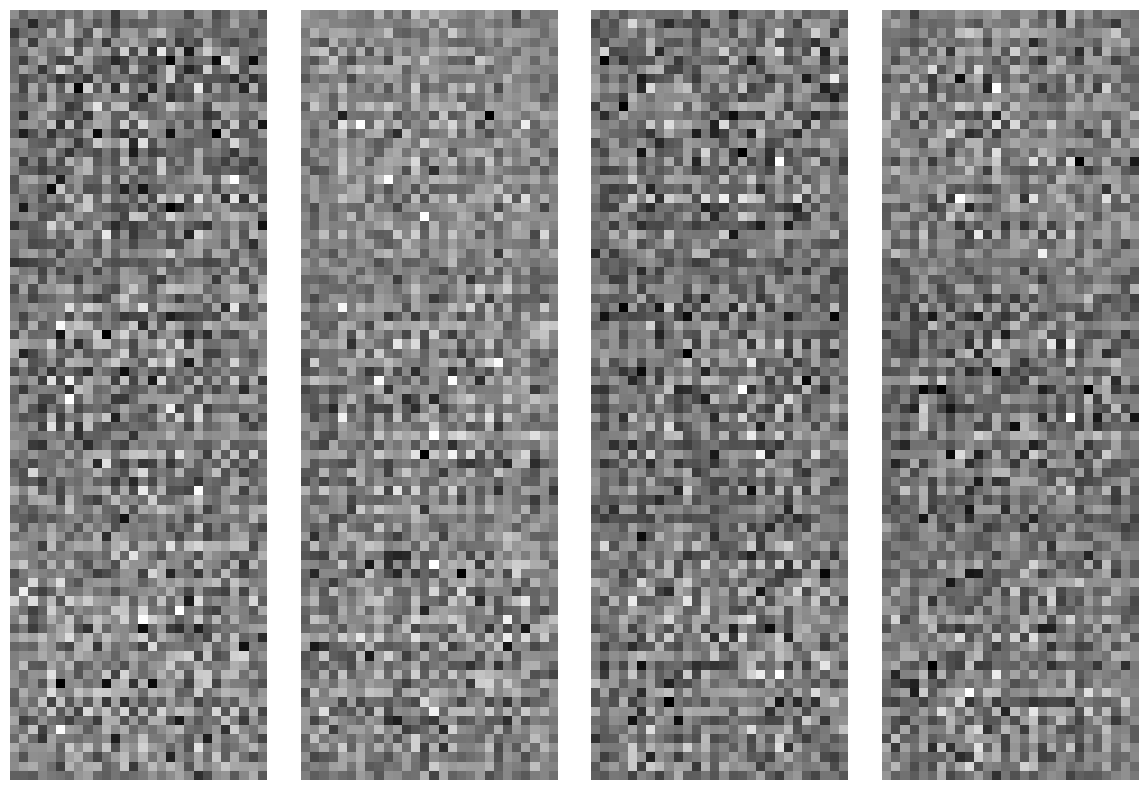

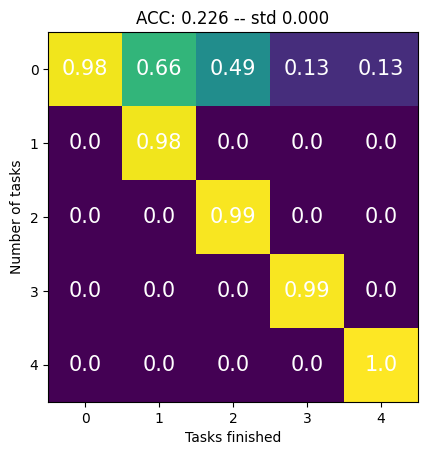

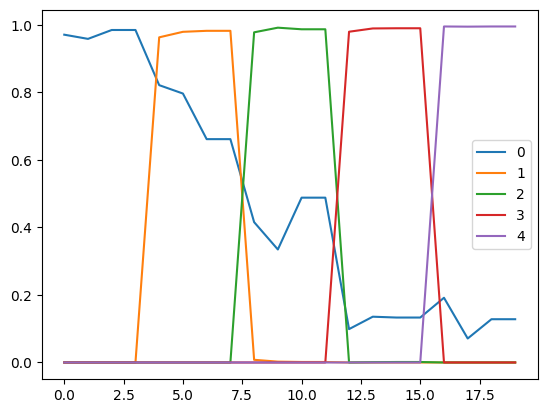

The average accuracy at the end of sequence is: 0.225
BWT:'-0.954'
FWT:'-0.131'


In [119]:
args = {
    'lr_gen': 2e-4,
    'lr_sol': 1e-5,
    'bs': 256,
    'epochs_gen': [10,10,20,20],
    'epochs_sol': 3,
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 256,
    'n_gen_samples': 60000,
    'z_dim': 100,
    'nz': 100,
    'ngf': 128,
    'ndf': 128,
    'nc': 1,
    'ngpu': 1,
    'device': device,
    'g_output_dim': 28*28,
    'gen_max_iters': 100000,
    }

classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='./dataMNIST/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

agent = Agent(args, train_tasks, val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")